# How do NNs work?

In this notebook, we want to motivate and understand how neural networks work from scratch. 


Steps:

1. [x] Plot a lambda function using `matplotlib`.
2. [x] Define a class of polynomial functions.
3. [x] Define a class of quadratic functions.
4. [x] Plot a quadratic function by its parameters.
5. [x] Generate noised data using `torch`.
6. [x] Interactively change function parameters `W` to fit points (visually).
    1. [x] Add MAE to the title and conduct guided change of `W`.
7. [x] Automate the process using gradient descent and torch.
8. [x] Visualize the universality of NNs by plotting them w.r.t their parameters.

In [26]:
%load_ext autoreload
%autoreload 2
%pdb on

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned ON


In [27]:
import os
from pathlib import Path
import jupyter_plz
from functools import partial

In [97]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [282]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Let's start by plotting a lambda over a range:

In [30]:
def plot_fun(f, x0, x1, y0=None, y1=None, figsize=(2, 2)):
    
    # generate 100 points between `x0` and `x1`
    x = torch.linspace(x0, x1, steps=100)
    
    # Use the function to calculate the corresponding `y`s
    y = f(x)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x, y)
    if y0 and y1:
        ax.ylim((y0, y1))
    plt.show()

Let's test the function:

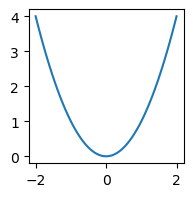

In [31]:
f = lambda x: x**2
plot_fun(f, -2, 2)

Next, let's define a function that returns `f(x)` of an N-degree polynomial: 

In [32]:
def p(w, x):
    N = len(w) - 1
    y = 0
    for i, j in enumerate(range(N, -1, -1)):
        y += w[i]*(x**j)
    return y

Let's plot the previous function using the `partial` operator:

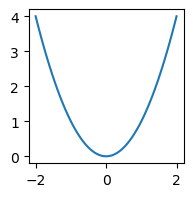

In [33]:
plot_fun(partial(p, [1, 0, 0]), -2, 2)

Let's define the class of quadratic functions:

In [34]:
def quad(a, b, c):
    return partial(p, [a, b, c])

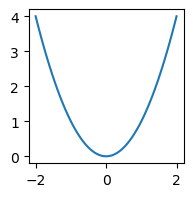

In [35]:
plot_fun(quad(1, 0, 0), -2, 2, figsize=(2, 2))

As we now have defined and visualized an `exact` function, let's generate noised data points for the purposes of function fitting:

- The noise will be generated on the `y`s.

In [82]:
def noise(y, mu: float = 0.0, std: float = 1):
    return torch.randn(*y.shape) * std + mu

Finally, let's create a function that take a function and noise-params and returns the `x`s and `y`s for plotting:

In [90]:
def get_points(f, a, b, nmu=0.0, nstd=1.0):
    x = torch.linspace(a, b, steps=100)
    y = f(x).squeeze()
    y_ = y + noise(y, nmu, nstd)
    return x, y, y_

Let's plot some:

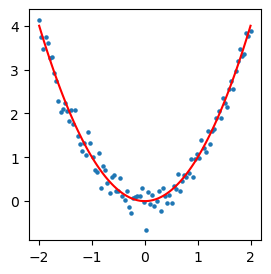

In [95]:
x, y, y_ = get_points(quad(1, 0, 0), -2, 2, nstd=.2)

# Plot
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(x, y_, s=5)
ax.plot(x, y, color="red")
plt.show()

Let's change the parameters of the function and check how does it fit the noised data points. 

We also want to create a quantitative feedback loop in the form of `MAE` and add it into the figure title:

In [113]:
# The starting points
a0, b0, c0 = 1.5, 1.5, 1.5

# Generate noised points based on the true function
_, _, y_ = get_points(quad(1, 0, 0), -2, 2, nstd=.2)

@interact(a=a0, b=b0, c=c0)
def plot_func(a, b, c):
    x, y, _ = get_points(quad(a, b, c), -2, 2, nstd=.2)
    fig, ax = plt.subplots()
    ax.scatter(x, y_, s=5)
    ax.plot(x, y, color="red")
    ax.set_title(f"MAE: {torch.abs(y - y_).mean():.2f}")
    plt.show()

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

Now it's time to automate the process of finding the best parameters using **gradient descent**.

Gradient descent can be formalized as follows:

$$\theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j}J(\theta)$$

Let's implement it using `torch`:

In [219]:
# Set the learning rate
lr = .01

# Get the true `x -> y` mapping
x, y, _ = get_points(quad(1, 0, 0), -2, 2, nstd=.2)

# Reshape the targets
y = y[None, :]

# Initialize parameters
W = torch.Tensor([1.5, 1.5, 1.5])[None, :]
W.requires_grad_()

# Prepare feature vector
X = torch.cat([(x**2)[None, :], x[None, :], torch.ones_like(x)[None, :]])

# Predict
y_hat = torch.matmul(W, X)

# Calculate MAE
loss = torch.abs(y - y_hat).mean()
print(f"MAE: {loss}")
loss.backward()

# Update
with torch.no_grad():
    W -= lr*W.grad
    
# Predict
y_hat = torch.matmul(W, X)

# Calculate MAE
loss = torch.abs(y - y_hat).mean()
print(f"MAE: {loss}")

MAE: 2.1801347732543945
MAE: 2.1516313552856445


Let's create a 10-step loop to optimize the parameters:

In [220]:
lr = .01

In [221]:
for i in range(1000):
    
    # Predict
    y_hat = torch.matmul(W, X)

    # Calculate MAE
    loss = torch.abs(y - y_hat).mean()
    if i % 250 == 0: 
        lr /= 10.
        print(f"MAE: {loss}")
    loss.backward()

    # Update
    with torch.no_grad():
        W -= lr*W.grad

MAE: 2.1516313552856445
MAE: 1.5186166763305664
MAE: 1.048815369606018
MAE: 0.2889229357242584


Finally, let's plot the learnt function:

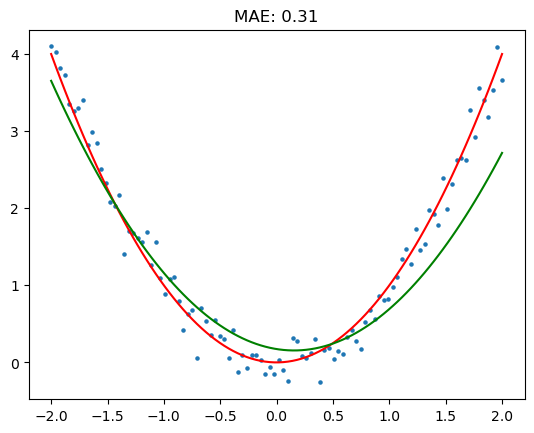

In [235]:
# Plot the final results
fig, ax = plt.subplots()
ax.scatter(x, y_, s=5)
ax.plot(x, y.squeeze(), color="red")
ax.plot(x, y_hat.detach().squeeze(), color="green")
ax.set_title(f"MAE: {torch.abs(y - y_hat).mean():.2f}")
plt.show()

What we want to finally demonstrate is how universal neural nets are using torch:

We will use only linear layers with ReLUs:

In [388]:
# Create the neural network
def NN(num_layers=1):
    nns = list()
    i, j = 1, 2
    for _ in range(num_layers):
        nns.extend([
            nn.Linear(i, j),
            nn.ReLU()
        ])
        i, j = j, j*2
    _ = nns.pop()
    _ = nns.pop()
    nns.append(nn.Linear(int(j/4), 1))
    return nn.Sequential(*nns)

Let's plot the resulting functions for `1 -> 10` layers:

In [395]:
x = torch.linspace(-1., 1., steps=100)[:, None]
x.shape

torch.Size([100, 1])

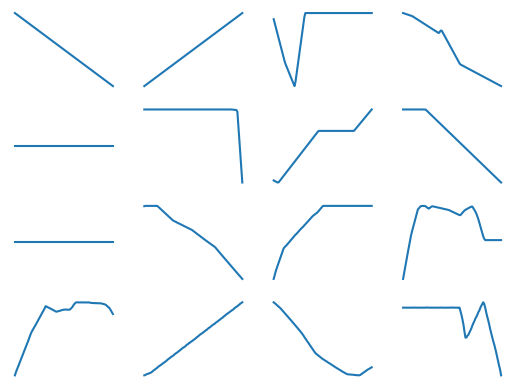

In [396]:
fig, axs = plt.subplots(4, 4)

for i in range(16):
    
    # Get predictions
    y_hat = NN(i+1)(x).squeeze().detach()
    
    # Plot
    row = i // 4
    col = i % 4
    axs[row, col].plot(x.squeeze(), y_hat)
    axs[row, col].axis('off')

---